In [25]:
import clumpsptm
import pandas as pd
import os
import numpy as np
import glob
from tqdm import tqdm
import subprocess
import ast
from agutil.parallel import parallelize2
import matplotlib.pyplot as plt

---

__Author__:  Shankara Anand

__Email__: sanand@broadinstitute.org

This notebook walks through how to take a source dataset of PTM sites and map them to PDB structures to eventually use with PTM-CLUMPS. This is necessary pre-processing for a new dataset to map the feature space onto available structures. This notebook specifically walks through steps used in [CPTAC PanCancer project](https://github.com/getzlab/CPTAC_PanCan_2021).

---

In [2]:
# Reference Files
UNIPROT_SWISSPROT = "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
SIFTS_DB = "ftp://ftp.ebi.ac.uk/pub/databases/msd/sifts/flatfiles/tsv/pdb_chain_uniprot.tsv.gz"

# Source Files
CPTAC_REFSEQ_FASTA = "../../CPTAC_PanCan_2021/data/ref/genomic/RefSeq.20180629_Human_ucsc_hg38_cpdbnr_mito_264contams_553smORFs.fasta"
CPTAC_FEATURE_FILE = "../../CPTAC_PanCan_2021/data/processed/061721/var_map_full.tsv"

# Downloaded Database
PDB_DIR = "../../getzlab-CLUMPS2/clumps/db/ref/pdbs"

# Output Directory
REF_DIR = "example_refseq"

# Other
n_proteins_for_demo = 100
n_threads = 16

## 1. Download Reference Files
---

* We are mapping our source fasta (from CPTAC) to the Uniprot Swissprot annotated database
* We use the Sifts protein database for mapping Uniprot files to annotated PDB protein chains

In [3]:
clumpsptm.mp.dl_ref(REF_DIR, [UNIPROT_SWISSPROT, SIFTS_DB])

   * Downloading uniprot_sprot.fasta.gz...
   * Downloading pdb_chain_uniprot.tsv.gz...


## 2. Split Source Fasta
---

* Splits source fasta (from CPTAC) into individual protein sequence fastas for easy paralell processing
* Will select only 5 sequences to use blasting for example purposes

In [3]:
clumpsptm.mp.split_fastas(
    CPTAC_REFSEQ_FASTA,
    os.path.join(REF_DIR, "refseq_fastas"),
)

100%|██████████| 42311/42311 [00:02<00:00, 14395.09it/s]


In [4]:
refseq_individual_fastas = glob.glob(os.path.join(REF_DIR, "refseq_fastas/*"))[:n_proteins_for_demo]
refseq_individual_fastas[:10]

['example_refseq/refseq_fastas/NP_061943.2.seq',
 'example_refseq/refseq_fastas/NP_001316327.1.seq',
 'example_refseq/refseq_fastas/NP_001275683.1.seq',
 'example_refseq/refseq_fastas/NP_004205.2.seq',
 'example_refseq/refseq_fastas/NP_001159737.1.seq',
 'example_refseq/refseq_fastas/NP_066568.3.seq',
 'example_refseq/refseq_fastas/NP_776170.2.seq',
 'example_refseq/refseq_fastas/NP_001263215.1.seq',
 'example_refseq/refseq_fastas/NP_001333622.1.seq',
 'example_refseq/refseq_fastas/NP_001191226.1.seq']

## 3. Blast Protein Sequences
---

* Use clumps-ptm module to run blastp+ with easy scaling via multi-threading
* For full CPTAC source fasta (~22947 sequences to blast), this requires roughly 1 hr of run-time with an `n1-standard-96` on Google Cloud Compute using `384` threads

In [5]:
%%time

clumpsptm.mp.blast_sequences(
    os.path.join(REF_DIR, "uniprot_sprot.fasta"),
    refseq_individual_fastas,
    output_dir=REF_DIR,
    n_threads=n_threads,
    db_title="UniprotDB",
    blast_dir_name="refseq_to_uniprot_blast",
    seq_db_name="uniprot_db"
)



Building a new DB, current time: 07/25/2022 23:18:12
New DB name:   /home/sanand/CLUMPS-PTM/examples/example_refseq/uniprot_db/uniprot_db
New DB title:  UniprotDB
Sequence type: Protein
Deleted existing Protein BLAST database named /home/sanand/CLUMPS-PTM/examples/example_refseq/uniprot_db/uniprot_db
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 567483 sequences in 15.8375 seconds.

   * Running 100 blast sequences using 16 threads
CPU times: user 146 ms, sys: 478 ms, total: 624 ms
Wall time: 4min 53s


## 4. Cross-Reference with Sifts Data-Base
---

In [5]:
sifts_df = pd.read_csv(os.path.join(REF_DIR, "pdb_chain_uniprot.tsv"), comment="#", sep='\t')

In [6]:
blasted_files = glob.glob(os.path.join(REF_DIR, "refseq_to_uniprot_blast/*"))
blasted_files[:10]

['example_refseq/refseq_to_uniprot_blast/NP_039236.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001191231.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001289928.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001336478.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001616.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_835454.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_005083.2.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001308477.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001307809.1.blasted.seq.gz',
 'example_refseq/refseq_to_uniprot_blast/NP_001186782.1.blasted.seq.gz']

In [7]:
mapped_acc_df = clumpsptm.mp.get_blast_hits_with_sifts(blasted_files, sifts_df)
#mapped_acc_df = clumpsptm.mp.get_blast_hits_with_sifts(blasted_files, sifts_df, filter_only_human=True)
mapped_acc_df

100%|██████████| 100/100 [00:04<00:00, 24.01it/s]


,Hit_def,Hsp_num,Hsp_bit-score,Hsp_score,Hsp_evalue,Hsp_query-from,Hsp_query-to,Hsp_hit-from,Hsp_hit-to,Hsp_query-frame,...,Hsp_gaps,Hsp_align-len,Hsp_qseq,Hsp_hseq,Hsp_midline,relIdentity,uniprot,species,sifts,blast
query,,,,,,,,,,,,,,,,,,,,,
NP_039236.1,sp|P23760|PAX3_HUMAN Paired box protein Pax-3 ...,1,751.51,1939,0,1,473,1,478,0,...,19,485,MAALPGTVPRMMRPAPGQNYPRTGFPLEVSTPLGQGRVNQLGGVFI...,MTTLAGAVPRMMRPGPGQNYPRSGFPLEVSTPLGQGRVNQLGGVFI...,M L G VPRMMRP PGQNYPR+GFPLEVSTPLGQGRVNQLGGVFI...,0.771134,P23760,HUMAN,True,True
NP_001191231.1,sp|P05067|A4_HUMAN Amyloid-beta precursor prot...,1,1511.12,3911,0,1,733,1,770,0,...,37,770,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,0.950649,P05067,HUMAN,True,True
NP_001289928.1,sp|P81139|LIPR2_CAVPO Pancreatic lipase-relate...,1,153.295,386,6.28424e-40,17,334,13,349,0,...,45,350,NKRPCLEFSQLSVKDSFRDLFIPRIETILMMYTRNNLNCAEPLFEQ...,DEKPWAGTSQRPIKSLPSDP--KKINTRFLLYTNENQNSYQLITAT...,+++P SQ +K D +I T ++YT N N + + ...,0.297143,P81139,CAVPO,True,True
NP_001336478.1,sp|Q91YI6|GLD2_MOUSE Poly(A) RNA polymerase GL...,1,926.776,2394,0,1,509,1,484,0,...,25,509,MFPNSILGRPPFTPNHQQHNNFFTLSPTVYSHQQLIDAQFNFQNAD...,MFPNSILGRPPFTPTHQQHNNFFALSPTLYSHQQLIDAQFNFQNVD...,MFPNSILGRPPFTP HQQHNNFF LSPT+YSHQQLIDAQFNFQN D...,0.880157,Q91YI6,MOUSE,True,True
NP_001616.1,"sp|P54819|KAD2_HUMAN Adenylate kinase 2, mitoc...",1,490.73,1262,5.20366e-176,1,239,1,239,0,...,0,239,MAPSVPAAEPEYPKGIRAVLLGPPGAGKGTQAPRLAENFCVCHLAT...,MAPSVPAAEPEYPKGIRAVLLGPPGAGKGTQAPRLAENFCVCHLAT...,MAPSVPAAEPEYPKGIRAVLLGPPGAGKGTQAPRLAENFCVCHLAT...,1.0,P54819,HUMAN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_937839.1,sp|P40200|TACT_HUMAN T-cell surface protein ta...,1,1210.67,3131,0,1,585,1,585,0,...,0,585,MEKKWKYCAVYYIIQIHFVKGVWEKTVNTEENVYATLGSDVNLTCQ...,MEKKWKYCAVYYIIQIHFVKGVWEKTVNTEENVYATLGSDVNLTCQ...,MEKKWKYCAVYYIIQIHFVKGVWEKTVNTEENVYATLGSDVNLTCQ...,1.0,P40200,HUMAN,True,True
NP_001284484.1,sp|O14733|MP2K7_HUMAN Dual specificity mitogen...,1,860.907,2223,0,1,435,1,419,0,...,16,435,MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRPIIVIT...,MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRP-----...,MAASSLEQKLSRLEAKLKQENREARRRIDLNLDISPQRPRP ...,0.96092,O14733,HUMAN,True,True
NP_696961.2,sp|Q7L0J3|SV2A_HUMAN Synaptic vesicle glycopro...,1,73.1738,178,3.05011e-12,152,366,212,466,0,...,42,256,FAGVLVGAVAFGYLSDRFGRRRLLLVAYVSTLVLGLASAASVSYVM...,YLGMMVGAFLWGGLADRLGRRQCLLISLSVNSVFAFFSSFVQGYGT...,+ G++VGA +G L+DR GRR+ LL++ V S+ Y ...,0.269531,Q7L0J3,HUMAN,True,True


In [8]:
w_sifts = mapped_acc_df[(mapped_acc_df['blast']) & (mapped_acc_df['sifts'])].shape[0]
w_blast = mapped_acc_df[mapped_acc_df['blast']].shape[0]
tot = mapped_acc_df.shape[0]

print(" {} / {} ({:.2f} %) with blast results.".format(w_blast, tot, 100*w_blast/tot))
print(" {} / {} ({:.2f} %) with sifts results.".format(w_sifts, tot, 100*w_sifts/tot))

 100 / 100 (100.00 %) with blast results.
 78 / 100 (78.00 %) with sifts results.


## 5. Filter SIFTS with Downloaded PDBs
---

In [9]:
pdbstore = clumpsptm.PdbStore(PDB_DIR)
print(pdbstore)

# Sifts that overlap Uniprots
sifts_filt_df = sifts_df[sifts_df['SP_PRIMARY'].isin(mapped_acc_df['uniprot'])]

PDBStore
   * 108990 PDB files downloaded
   * Directory Path: ../../getzlab-CLUMPS2/clumps/db/ref/pdbs


In [10]:
missing_pdbs = set(sifts_filt_df['PDB']) - pdbstore.downloaded_pdbs

print("Missing {} / {} ({:.2f} %) PDB files.".format(
    len(missing_pdbs), 
    len(set(sifts_filt_df['PDB'])), 
    (100*len(missing_pdbs))/(len(set(sifts_filt_df['PDB'])))))

# Drop PDBs unable to be downloaded
sifts_filt_df = sifts_filt_df[sifts_filt_df["PDB"].isin(pdbstore.downloaded_pdbs)]

Missing 61 / 560 (10.89 %) PDB files.


## 6. Match PTMs from Source Data-Set to Uniprot-Mapped Proteins
---
* Note: only one matched protein has PTM data in this example

In [11]:
pmap_df = pd.read_csv(CPTAC_FEATURE_FILE, sep='\t', index_col=0)
ptm_df = pmap_df[pmap_df['feature'].isin(['phosphoproteome','acetylome'])].dropna(1)
ptm_df.head(3)

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id.description,geneSymbol,protein_mw,accession_number,feature,variableSites,sequence,sequenceVML
id,,,,,,,,
NP_001333374.1_S18s_1_1_18_18,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S18s', 'S18s']","['ELLLPNWQGsGSHGLTIAQR', 'ELLLPNWQGsGSHGLTIAQR']","['ELLLPNWQGS(0.99)GS(0.0)HGLT(0.0)IAQR', 'ELLL..."
NP_001333374.1_S41s_1_1_41_41,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S41s', 'S41s']","['DDGVFVQEVTQNsPAAR', 'DDGVFVQEVTQNsPAAR']","['DDGVFVQEVT(0.0)QNS(0.99)PAAR', 'DDGVFVQEVT(0..."
NP_001333374.1_S93s_1_1_93_93,neuroblast differentiation-associated protein...,AHNAK,629603.7,NP_001333374.1,phosphoproteome,"['S93s', 'S93s', 'S93s', 'S93s']","['GDRsPEPGQTWTR', 'KGDRsPEPGQTWTR', 'KGDRsPEPG...","['GDRS(0.99)PEPGQT(0.0)WT(0.0)R', 'KGDRS(0.99)..."


In [12]:
def grab_ptm_site(x):
    """Grab actual PTM site."""
    res = list()
    
    for s in x.split(" "):
        if s.startswith(("K","Y","S","T")):
            res.append(s)
        else:
            pass
        
    if len(res) == 1:
        return res[0]
    else:
        return res

# Expand PTMs in Each Feature
ptm_df['variableSites'] = ptm_df['variableSites'].apply(ast.literal_eval)
ptm_df = ptm_df.explode('variableSites').drop_duplicates()

# Proteins with single PTM sites
ptm_sing_df = ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="1" and x.split("_")[-4]=="1")]
ptm_sing_df.loc[:,"ptmSite"] = ptm_sing_df['variableSites'].apply(grab_ptm_site)

# Proteins with multiple PTM sites
ptm_multi_df = pd.concat((
    ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="3" and x.split("_")[-4]=="3")],
    ptm_df.loc[ptm_df.index.map(lambda x: x.split("_")[-3]=="2" and x.split("_")[-4]=="2")]
))

ptm_multi_df.loc[:,"ptmSite"] = ptm_multi_df['variableSites'].apply(grab_ptm_site)
ptm_multi_df = ptm_multi_df.explode("ptmSite")

# Combine & intersect accession numbers
ptm_comb_df = pd.concat((ptm_sing_df, ptm_multi_df))
ptm_comb_df = ptm_comb_df[ptm_comb_df["accession_number"].isin(mapped_acc_df.index)]

# Join PTM features from source data-set to mapped accession-numbers
ptm_comb_df = pd.merge(
    ptm_comb_df.reset_index(), 
    mapped_acc_df.reset_index().rename(columns={"query":"accession_number"}),
    how="left",
    on="accession_number"
).set_index("id")

ptm_comb_df["acc_res"] = ptm_comb_df["ptmSite"].apply(lambda x: x[0])
ptm_comb_df["acc_res_i"] = ptm_comb_df["ptmSite"].apply(lambda x: int(x[1:-1]))

print("  * {} single PTM sites total in CPTAC dataset".format(ptm_sing_df.shape[0]))
print("  * {} multi PTM sites total in CPTAC dataset".format(ptm_multi_df.shape[0]))

ptm_comb_df.head()

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


  * 133619 single PTM sites total in CPTAC dataset
  * 41394 multi PTM sites total in CPTAC dataset


,id.description,geneSymbol,protein_mw,accession_number,feature,variableSites,sequence,sequenceVML,ptmSite,Hit_def,...,Hsp_qseq,Hsp_hseq,Hsp_midline,relIdentity,uniprot,species,sifts,blast,acc_res,acc_res_i
id,,,,,,,,,,,,,,,,,,,,,
NP_001158136.1_S137s_1_1_137_137,microtubule-associated serine/threonine-prote...,MAST4,286317.4,NP_001158136.1,phosphoproteome,S137s,"['KCsNPDVASGPGK', 'KCsNPDVASGPGK']","['KCS(0.99)NPDVAS(0.0)GPGK', 'KCS(0.99)NPDVAS(...",S137s,sp|O15021|MAST4_HUMAN Microtubule-associated s...,...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,1.0,O15021,HUMAN,True,True,S,137
NP_001158136.1_S1283s_1_1_1283_1283,microtubule-associated serine/threonine-prote...,MAST4,286317.4,NP_001158136.1,phosphoproteome,S1283s,"['sFSCLNR', 'sFSCLNR']","['S(0.99)FS(0.0)CLNR', 'S(0.99)FS(0.0)CLNR']",S1283s,sp|O15021|MAST4_HUMAN Microtubule-associated s...,...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,1.0,O15021,HUMAN,True,True,S,1283
NP_001158136.1_S1309s_1_1_1309_1309,microtubule-associated serine/threonine-prote...,MAST4,286317.4,NP_001158136.1,phosphoproteome,S1309s,"['sPTPSYR', 'sPTPSYR']","['S(0.99)PT(0.0)PS(0.0)Y(0.0)R', 'S(0.99)PT(0....",S1309s,sp|O15021|MAST4_HUMAN Microtubule-associated s...,...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,1.0,O15021,HUMAN,True,True,S,1309
NP_001158136.1_S1370s_1_1_1370_1370,microtubule-associated serine/threonine-prote...,MAST4,286317.4,NP_001158136.1,phosphoproteome,S1370s,"['sAGNIPLSPLAR', 'sAGNIPLSPLAR']","['S(0.99)AGNIPLS(0.0)PLAR', 'S(0.99)AGNIPLS(0....",S1370s,sp|O15021|MAST4_HUMAN Microtubule-associated s...,...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,1.0,O15021,HUMAN,True,True,S,1370
NP_001158136.1_S1384s_1_1_1384_1384,microtubule-associated serine/threonine-prote...,MAST4,286317.4,NP_001158136.1,phosphoproteome,S1384s,"['TPsPTPQPTSPQR', 'TPsPTPQPTSPQR']","['T(0.0)PS(0.99)PT(0.0)PQPT(0.0)S(0.0)PQR', 'T...",S1384s,sp|O15021|MAST4_HUMAN Microtubule-associated s...,...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,MGEKVSEAPEPVPRGCSGHGSRTPASALVAASSPGASSAESSSGSE...,1.0,O15021,HUMAN,True,True,S,1384


In [13]:
# Filter
ptm_comb_filt_df = ptm_comb_df[ptm_comb_df['Hsp_query-from'].notna()].copy()
ptm_comb_filt_df['Hsp_query-from'] = ptm_comb_filt_df['Hsp_query-from'].astype(int)
ptm_comb_filt_df['Hsp_hit-from'] = ptm_comb_filt_df['Hsp_hit-from'].astype(int)

def get_source_blast_idx(row):
    """
    Get source blast index.
    """
    d = dict()
    c = row['Hsp_query-from']

    for idx,res in enumerate(row['Hsp_qseq']):
        if res is not '-':
            d[c] = idx
            c = c+1
    
    if row['acc_res_i'] not in d.keys():
        return "X"
    else:
        return d[row['acc_res_i']]

def get_uniprot_blast_i(row):
    """
    Get Uniprot Mapped Residue ID.
    """
    d = dict()
    c = row['Hsp_hit-from']

    for idx,res in enumerate(row['Hsp_hseq']):
        if res is not '-':
            d[idx] = c
            c = c+1

    if row['acc_res_idx'] not in d.keys():
        return "X"
    else:
        return d[row['acc_res_idx']]

def _get_qres(row):
    """Get query residue"""
    try:
        return row["Hsp_qseq"][row["acc_res_idx"]]
    except:
        return None

def _get_hres(row):
    """Get query residue"""
    try:
        return row["Hsp_hseq"][row["acc_res_idx"]]
    except:
        return None

ptm_comb_filt_df["acc_res_idx"] = ptm_comb_filt_df.apply(get_source_blast_idx, 1)
ptm_comb_filt_df["acc_res"] = ptm_comb_filt_df.apply(_get_qres, 1)

# Get Uniprot Matches
ptm_comb_filt_df["uniprot_res"] = ptm_comb_filt_df.apply(_get_hres, 1)
ptm_comb_filt_df["uniprot_res_i"] = ptm_comb_filt_df.apply(get_uniprot_blast_i, 1)
ptm_comb_filt_df['uniprot_match'] = ptm_comb_filt_df['acc_res']==ptm_comb_filt_df['uniprot_res']

## 7. Align Source PTMs to PDB Residues via SIFTS
---

In [14]:
sifts_filt_df['PDB_BEG'] = sifts_filt_df['PDB_BEG'].apply(lambda x: 0 if x=="None" else x)
sifts_filt_df['len'] = sifts_filt_df['RES_END'] - sifts_filt_df['RES_BEG']
sifts_drop_dup = sifts_filt_df.drop_duplicates(subset=['PDB','len'])

ptm_comb_filt2_df = ptm_comb_filt_df[ptm_comb_filt_df["uniprot_match"]].copy()

In [15]:
%%time

pdb_headers = dict()
n_threads=n_threads

@parallelize2(maximum=n_threads)
def get_header_info(idx_pdb_ch):
    """Download pdb."""
    try:
        idx,pdb,chain = idx_pdb_ch

        hd = pdbstore.load_header(pdb)
        pdb_headers[idx] = dict()

        for polymer in hd['polymers']:
            if polymer.chid == chain:
                for dbref in polymer.dbrefs:
                    pdb_headers[idx]["db_ref"] = dbref.database
                    pdb_headers[idx]["db_accession"] = dbref.accession
                    pdb_headers[idx]["db_first_from"] = dbref.first[0]
                    pdb_headers[idx]["db_first_to"] = dbref.first[2]

                    if dbref.accession == row["SP_PRIMARY"]:
                        continue
        return None
    except:
        return idx_pdb_ch
                    
vals = [x for x in zip(sifts_drop_dup.index, sifts_drop_dup['PDB'], sifts_drop_dup['CHAIN'])]
tpm = [get_header_info(val) for val in vals]
pdb_err = {callback() for callback in tpm}
pdb_headers = pd.DataFrame.from_dict(pdb_headers).T

CPU times: user 12.7 s, sys: 4.13 s, total: 16.9 s
Wall time: 9.01 s


In [16]:
sifts_drop_dup = sifts_drop_dup.join(pdb_headers)
sifts_drop_dup['db_match'] = sifts_drop_dup['SP_PRIMARY']==sifts_drop_dup['db_accession']

In [17]:
accession_numbers_to_use = np.intersect1d(
    mapped_acc_df[
        (mapped_acc_df['blast']) & (mapped_acc_df['sifts'])
    ].index,
    ptm_comb_filt2_df['accession_number']
)

print(accession_numbers_to_use)

['NP_000057.2' 'NP_000329.2' 'NP_001008240.1' 'NP_001129976.1'
 'NP_001137407.1' 'NP_001158136.1' 'NP_001159737.1' 'NP_001171908.1'
 'NP_001171915.1' 'NP_001254507.1' 'NP_001269115.1' 'NP_001284484.1'
 'NP_001310876.1' 'NP_001336478.1' 'NP_001616.1' 'NP_001761.3'
 'NP_003089.1' 'NP_005151.2' 'NP_005316.1' 'NP_005321.1' 'NP_056173.1'
 'NP_066568.3' 'NP_542192.2' 'NP_940947.3' 'NP_942133.1']


## 7.1 PDB Matches
---

In [18]:
%%time

clumpsptm.mp.get_acc_pdb_matches(
    accession_numbers_to_use,
    ptm_comb_filt2_df,
    sifts_drop_dup,
    pdbstore,
    os.path.join(REF_DIR, "pdb_matches"),
    4
)

CPU times: user 7.41 s, sys: 2.55 s, total: 9.95 s
Wall time: 8.91 s


{None}

## 8. Select Best PDB Structure
---


In [29]:
pdb_mapped_df = pd.concat([
    pd.read_parquet(x) for x in 
    glob.glob(os.path.join(REF_DIR, "pdb_matches/acc_mapped_sifts/*"))
])

pdb_mapped_df['db_match'] = pdb_mapped_df['db_match'].astype(bool)
pdb_mapped_df = pdb_mapped_df[pdb_mapped_df['db_match']]
pdb_mapped_df = pdb_mapped_df[pdb_mapped_df['db_ref']=='UniProt']
pdb_mapped_df['percent_match'] = pdb_mapped_df['percent_match'].astype(float)
pdb_mapped_df = pdb_mapped_df.sort_values(['percent_match','len','accession_number'], ascending=False)

# Select Top Structure by overlapping matched sites
pdb_mapped_filt_df = pdb_mapped_df.drop_duplicates(subset=['accession_number'])

_prev = pdb_mapped_filt_df.shape[0]
pdb_mapped_filt_df = pdb_mapped_filt_df[pdb_mapped_filt_df['percent_match']>0]
pdb_mapped_filt_df['len'] = pdb_mapped_filt_df['len'].astype(int)
print(" {} / {} ({:.2f} %) structures with matching sites".format(
    pdb_mapped_filt_df.shape[0], _prev, 100*pdb_mapped_filt_df.shape[0]/_prev))

 14 / 25 (56.00 %) structures with matching sites


Text(0, 0.5, 'PDB Length')

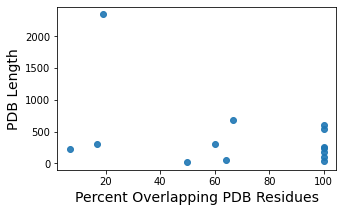

In [32]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(pdb_mapped_filt_df['percent_match'], pdb_mapped_filt_df['len'], alpha=0.9)
ax.set_xlabel("Percent Overlapping PDB Residues", fontsize=14)
ax.set_ylabel("PDB Length", fontsize=14)

In [33]:
pdb_mapped_filt_df

,PDB,CHAIN,SP_PRIMARY,RES_BEG,RES_END,PDB_BEG,PDB_END,SP_BEG,SP_END,len,db_ref,db_accession,db_first_from,db_first_to,db_match,percent_match,accession_number
58470,1xl7,A,Q9DC50,1,612,0,612,1,612,611,UniProt,Q9DC50,1,1,True,100.000000,NP_001137407.1
174536,3ojy,B,P07358,1,537,0,None,55,591,536,UniProt,P07358,1,55,True,100.000000,NP_000057.2
397057,5xtc,f,O43677,1,47,28,74,28,74,46,UniProt,O43677,28,28,True,100.000000,NP_001171915.1
63125,1z87,A,Q61234,1,263,2,264,2,264,262,UniProt,Q61234,2,2,True,100.000000,NP_003089.1
71308,2c9y,A,P54819,2,240,0,None,1,239,238,UniProt,P54819,1,1,True,100.000000,NP_001616.1
288151,4wj7,A,Q9BSQ5,3,180,0,None,51,228,177,UniProt,Q9BSQ5,51,51,True,100.000000,NP_542192.2
397059,5xtc,h,O43920,1,104,2,105,2,105,103,UniProt,O43920,2,2,True,100.000000,NP_001171908.1
130683,3cik,A,P25098,1,689,0,None,1,689,688,UniProt,P25098,1,1,True,66.666667,NP_005151.2
374558,5svy,A,Q14149,2,50,407,49,407,455,48,UniProt,Q14149,407,407,True,64.285714,NP_056173.1
532608,6yfz,A,O14733,2,307,116,421,100,405,305,UniProt,O14733,116,116,True,60.000000,NP_001284484.1


## 9. Finalize Sites
---
* Filter duplicates, etc.

In [35]:
sites_mapped_df = list()

for idx,row in tqdm(pdb_mapped_filt_df.iterrows(), total=pdb_mapped_filt_df.shape[0]):
    _df = pd.read_parquet(
        os.path.join(REF_DIR, "pdb_matches/acc_mapped_sites", "{}.parquet".format(row["accession_number"]))).loc[:,[
        "{}_{}_res_i".format(row["PDB"],row["CHAIN"]),
        "{}_{}_res".format(row["PDB"],row["CHAIN"]),
        "{}_{}_res_match".format(row["PDB"],row["CHAIN"])
    ]]
    
    _df.columns = ['pdb_res_i', 'pdb_res', 'pdb_res_match']
    _df['pdb'] = row["PDB"]
    _df['chain'] = row["CHAIN"]
    sites_mapped_df.append(_df)
    
sites_mapped_df = pd.concat(sites_mapped_df)

# Drop duplicates
sites_mapped_df = sites_mapped_df.reset_index().drop_duplicates().set_index("id")

# Select for matched sites / rank multi sites by position
sites_mapped_df = sites_mapped_df[sites_mapped_df['pdb_res_match']]
sites_mapped_df['pdb_res_i_rank'] = sites_mapped_df.reset_index().groupby("id")['pdb_res_i'].rank("dense").astype(int).values

100%|██████████| 14/14 [00:00<00:00, 142.40it/s]


In [36]:
sites_mapped_df

,pdb_res_i,pdb_res,pdb_res_match,pdb,chain,pdb_res_i_rank
id,,,,,,
NP_001137407.1_K386k_1_1_386_386,358,K,True,1xl7,A,1
NP_001137407.1_K523k_1_1_523_523,495,K,True,1xl7,A,1
NP_000057.2_S150s_1_1_150_150,96,S,True,3ojy,B,1
NP_000057.2_K259k_1_1_259_259,205,K,True,3ojy,B,1
NP_000057.2_K305k_1_1_305_305,251,K,True,3ojy,B,1
...,...,...,...,...,...,...
NP_942133.1_T1392t_1_1_1392_1392,1392,T,True,6g2d,B,1
NP_001761.3_T275t_1_1_275_275,275,T,True,7jic,A,1
NP_001254507.1_S467s_1_1_467_467,466,S,True,4tvs,A,1


In [37]:
# Drop duplicate ptmSites (i.e. NP_000005.2_K608k_1_1_608_608 - has two sites mapped from different cohorts)
ptm_comb_filt_pdb_df = ptm_comb_filt_df.reset_index().drop_duplicates(['id','ptmSite']).set_index('id')

# Rank multi-sites by position
ptm_comb_filt_pdb_df['pdb_res_i_rank'] = ptm_comb_filt_pdb_df.reset_index().groupby("id")['acc_res_i'].rank("dense").astype(int).values

# Combine pdb level annotations
ptm_comb_filt_pdb_df = pd.merge(ptm_comb_filt_pdb_df.reset_index(), sites_mapped_df.reset_index(), how='left').set_index('id')
ptm_comb_filt_pdb_df['pdb_res_match'] = ptm_comb_filt_pdb_df['pdb_res_match'].fillna(False)
ptm_comb_filt_pdb_df['pdb_res_match'] = (ptm_comb_filt_pdb_df['pdb_res_match']) & (ptm_comb_filt_pdb_df['pdb_res'] == ptm_comb_filt_pdb_df['acc_res'])

# Only matched sites
ptm_comb_filt_match_pdb_df = ptm_comb_filt_pdb_df[ptm_comb_filt_pdb_df['pdb_res_match']==True].copy()
ptm_comb_filt_match_pdb_df['pdb_res_i'] = ptm_comb_filt_match_pdb_df['pdb_res_i'].astype(int)

## 10. Save Files + Summary
---

In [38]:
ptm_comb_filt_pdb_df.to_csv(os.path.join(REF_DIR, "full_mapped_sites_to_pdbs.tsv"), sep='\t')
ptm_comb_filt_match_pdb_df.to_csv(os.path.join(REF_DIR, "mapped_sites_to_pdbs.tsv"), sep='\t')

In [39]:
print(" {} acetylsites mapped.".format(ptm_comb_filt_match_pdb_df.groupby('feature').size()['acetylome']))
print(" {} phosphosites mapped.".format(ptm_comb_filt_match_pdb_df.groupby('feature').size()['phosphoproteome']))
print(" {} unique accession numbers.".format(np.unique(ptm_comb_filt_match_pdb_df['accession_number']).shape[0]))
print(" {} unique uniprots.".format(np.unique(ptm_comb_filt_match_pdb_df['uniprot']).shape[0]))

 23 acetylsites mapped.
 43 phosphosites mapped.
 14 unique accession numbers.
 14 unique uniprots.
